In [41]:
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
df_states = gpd.read_file('Data/us-states.json')
df_fires = gpd.read_file('Data/mtbs_fire_locations.geojson')

In [ ]:
df_states

In [3]:
df_western_us = df_states[df_states['name'].isin(['California', 'Oregon', 'Washington', 'Nevada', 'Arizona', 'Idaho', 'Montana', 'Utah', 'Wyoming', 'Colorado', 'New Mexico'])]

<AxesSubplot:>

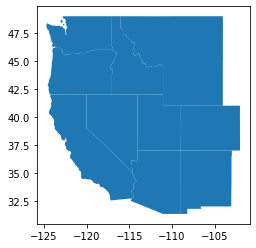

In [4]:
df_western_us.plot()

In [ ]:
gpd.GeoDataFrame(df_western_us).to_file('Data/western_us.geojson', driver='GeoJSON')

In [4]:
df_fires["Ig_Date"] = pd.to_datetime(df_fires["Ig_Date"])

In [5]:
df_fires["year"] = df_fires["Ig_Date"].dt.year

In [18]:
def timestamp_to_year_part(df):
    date = df["Ig_Date"][0]
    year = int(date.strftime("%Y"))
    print('{} / {}'.format(date,year))
    df.year.values[:] = year
    return df

In [8]:
# date_mask_1985 = (df_fires["Ig_Date"] >= '1985-01-01') & (df_fires["Ig_Date"] <= '1985-12-31')
# date_mask_2015 = (df_fires["Ig_Date"] >= '2015-01-01') & (df_fires["Ig_Date"] <= '2015-12-31')
fire_date_mask = (df_fires["Ig_Date"] >= '1985-01-01') & (df_fires["Ig_Date"] <= '2020-12-31')
fire_type_mask = (df_fires["Incid_Type"] != 'Prescribed Fire')
fire_size_mask = (df_fires["BurnBndAc"] >= 5000)
fire_location_mask = (df_fires["geometry"].within(df_western_us.unary_union))

In [9]:
# fires_1985 = df_fires[date_mask_1985 & fire_type_mask & fire_size_mask & fire_location_mask]
# fires_2015 = df_fires[date_mask_2015 & fire_type_mask & fire_size_mask & fire_location_mask]
western_fires = df_fires[fire_type_mask & fire_location_mask & fire_date_mask]

In [11]:
gpd.GeoDataFrame(western_fires).to_file('Data/western_fires.geojson', driver='GeoJSON')

/home/jake/miniconda3/envs/rstools/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
df_fires.assign(year=np.int32(0))
df_fires = df_fires.apply(timestamp_to_year_part, axis=1)

In [14]:
def extract_state(df):
    df["State"] = df["Event_ID"].apply(lambda x: x[0:2])
    return df

In [17]:
western_fires = extract_state(western_fires)

/home/jake/miniconda3/envs/rstools/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
states = {
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "ID": "Idaho",
    "MT": "Montana",
    "NV": "Nevada",
    "NM": "New Mexico",
    "OR": "Oregon",
    "UT": "Utah",
    "WA": "Washington",
    "WY": "Wyoming"
}

In [19]:
western_fires["State"] = western_fires["State"].apply(lambda x: states[x])

/home/jake/miniconda3/envs/rstools/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [21]:
burned_area_per_year_per_state = pd.DataFrame(western_fires.groupby(["State", "year"])["BurnBndAc"].sum())

In [31]:
burned_area_per_year_per_state = burned_area_per_year_per_state.sort_values(by="BurnBndAc", ascending=False)

In [32]:
burned_area_per_year_per_state

,State,year,BurnBndAc
69,California,2020,4528714
115,Idaho,2007,2157768
119,Idaho,2012,1719025
172,Nevada,1999,1659858
327,Wyoming,1988,1510922
...,...,...,...
182,Nevada,2010,5626
6,Arizona,1991,5590
296,Washington,1989,5442
286,Utah,2014,5373


In [33]:
burned_area_per_year_per_state.to_csv("Data/burned_area_per_year_per_state.csv")

In [44]:
western_fires[western_fires["BurnBndAc"] > 400000]

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,Pre_ID,Post_ID,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,ORIG_FID,geometry,year,State
2268,WY4470811082119880722,None,NORTH FORK,Wildfire,10014217,MTBS,Extended,563527,44.678,-110.716,1988-07-22,503802919860818,403802919890802,None,36,45,-970,-150,115,343,610,NPS burn area boundary (NPS WF Feature Server)...,2268,POINT (-110.80083 44.70808),1988,Wyoming
9765,AZ3423311046320020618,None,RODEO,Wildfire,12406,MTBS,Extended,461774,34.233,-110.463,2002-06-18,703603620010501,503603620030429,None,78,-9999,-970,-150,150,237,390,May include Chediski fire,9765,POINT (-110.46325 34.23326),2002,Arizona
9860,OR4244112390420020713,None,BISCUIT COMPLEX (BISCUIT),Wildfire,12658,MTBS,Extended,495308,42.441,-123.904,2002-07-13,504603120010819,504603120030825,None,5,-9999,-970,-150,125,330,580,North end cut off due to scene edge,9860,POINT (-123.91506 42.29725),2002,Oregon
14580,ID4216011532120070721,None,MURPHY COMPLEX,Wildfire,15886,MTBS,Initial,567409,42.160,-115.321,2007-07-21,504003120060908,504003120070911,None,48,-9999,-970,-150,140,211,350,None,14580,POINT (-115.32143 42.16024),2007,Idaho
19651,AZ3360210944920110529,None,WALLOW,Wildfire,2808,MTBS,Extended,563664,33.799,-109.253,2011-05-29,503503620110514,703503620120524,None,-33,-9999,-970,-150,10,190,400,None,19651,POINT (-109.29495 33.79803),2011,Arizona
20741,OR4239211789420120708,None,LONG DRAW,Wildfire,2363,MTBS,Initial (SS),557620,42.428,-117.625,2012-07-08,None,704203020120728,None,-9999,-9999,9999,9999,-100,-9999,-9999,None,20741,POINT (-117.63663 42.44043),2012,Oregon
20915,NV4197311836620120805,None,HOLLOWAY,Wildfire,1729,MTBS,Initial,457931,41.998,-118.248,2012-08-05,504203120110904,704203120120829,None,12,-9999,-970,-150,60,301,570,Water tower fire was before Holloway fire mapp...,20915,POINT (-118.25294 42.01199),2012,Nevada
27468,NV4152811742720180705,2980EF8D-E188-4A96-AAE6-B133D4706BB9,MARTIN,Wildfire,10010599,MTBS,Initial,432180,41.609,-116.94,2018-07-05,804203120170702,804203120180806,None,19,11,-970,-150,100,310,9999,slight overestimation of moderate due to some ...,27468,POINT (-116.97469 41.60214),2018,Nevada
27583,CA3924012311020180727,25B938AB-3047-4D7B-ADE3-FD752F156F7C,RANCH,Wildfire,10014566,MTBS,Extended,427048,39.269,-122.775,2018-07-27,804503320170723,804503320190814,None,-24,36,-970,-150,55,302,575,Used modified geomac perimeter.,27583,POINT (-122.76003 39.27885),2018,California
28876,CA3966012280920200817,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,AUGUST COMPLEX,Wildfire,10021108,MTBS,Extended,1068802,39.94,-123.03,2020-08-17,804503220200715,804503220210718,804503220201019,37,34,-970,-150,110,309,550,"CA4012512307320200818, CA4008712298420200819, ...",28876,POINT (-122.99685 39.93761),2020,California
